#Description

    ##Quality control on 150520 MiSeq data
        post-merging and demultiplexing



# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/150520_run1/QC/'
varSeqDir = '/var/seq_data/RhizCG/150520_run1/raw/'
databaseDir = '/home/bryan/RhizCG/data/databases/'

seqFile = 'pear_merged-2015-06-01.assembled.dmult.fastq'
nprocs = 20

#Init

In [2]:
from screed.fasta import fasta_iter
from pandas import DataFrame
import os
import re
import pandas as pd
from cogent import DNA
from qiime.assign_taxonomy import UclustConsensusTaxonAssigner
from IPython.display import Image
from image_novice import novice

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

Use suppressPackageStartupMessages to eliminate package startup messages.

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

In [7]:
!cd $workDir; ln -s -f ../$seqFile

#Merged read quality filtering

##Discard sequences that exceed max expected error threshold

In [8]:
%%bash -s "$workDir" "$seqFile" "$nprocs"

# max expected error
maxee=1

tmpdir1=`mktemp -d`
trap "rm -r $tmpdir1" 1 2 3 15
split -d -l 2000000 $1$2 $tmpdir1/Block

tmpdir2=`mktemp -d`
trap "rm -r $tmpdir2" 1 2 3 15
ls $tmpdir1/Block?? | parallel --gnu -j $3 -k "usearch -fastq_filter {} -fastq_maxee $maxee \
-fastaout $tmpdir2/{#}.fasta >/dev/null 2>&1 && cat $tmpdir2/{#}.fasta" > $1$2_maxee1.fasta
rm -r $tmpdir2 $tmpdir1

In [9]:
nlines = !cd $workDir; wc -l $seqFile
nlines = re.sub(" .+","", nlines[0])
nlines = int(nlines)
print "number of sequences pre-filter: {}".format(nlines/4)

maxee1 = seqFile + "_maxee1.fasta"
nlines2 = !cd $workDir; wc -l $maxee1
nlines2 = re.sub(" .+","", nlines2[0])
nlines2 = int(nlines2)
print "number of sequences post-filter: {}".format(nlines2/2)

number of sequences pre-filter: 8037686
number of sequences post-filter: 7973216


In [11]:
# %%bash -s "$workDir" "$seqFile" "$nprocs"

#cd $1

#printf "Number of sequence pre-filter: "
#wc -l $2 

#printf "Number of sequences post-filter: "
#grep -c ">" $2_maxee1.fasta

#echo '' 
#head -n 8 $2_maxee1.fasta

#Remove sequences with "N"

In [12]:
%%bash -s "$workDir" "$seqFile"

cd $1

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $2_maxee1.fasta > $2_maxee1_noN.fasta

printf "Number of sequence pre-filter: "
grep -c ">" $2_maxee1.fasta

printf "Number of sequences post-filter: "
grep -c ">" $2_maxee1_noN.fasta

Number of sequence pre-filter: 7973216
Number of sequences post-filter: 7973216


## Alignment-based QC with Mothur

In [13]:
%%bash -s "$workDir" "$seqFile"

cd $1

mothur "#unique.seqs(fasta=$2_maxee1_noN.fasta)" 







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > unique.seqs(fasta=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.fasta)
1000	923
2000	1841
3000	2711
4000	3590
5000	4466
6000	5322
7000	6179
8000	7046
9000	7894
10000	8747
11000	9582
12000	10396
13000	11214
14000	12031
15000	12842
16000	13645
17000	14418
18000	15225
19000	16006
20000	16804
21000	17593
22000	18380
23000	19152
24000	19922
25000	20672
26000	21439
27000	22224
28000	23008
29000	23804
30000	24572
31000	25359
320

In [16]:
%%bash -s "$workDir" "$seqFile"

cd $1

printf "Number of unique sequences: "
grep -c ">" $2_maxee1_noN.unique.fasta

Number of unique sequences: 4446541


In [15]:
%%bash -s "$workDir" "$seqFile"
# making mothur group file

cd $1

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $2_maxee1_noN.fasta > group_file.txt

head group_file.txt

sample3-4.15_Nneg_0	sample3-4.15_Nneg
sample5-1.06_Nneg_1	sample5-1.06_Nneg
sample6-4.27_Nneg_2	sample6-4.27_Nneg
sample1-4.27_Nneg_3	sample1-4.27_Nneg
sample5-1.16_Npos_4	sample5-1.16_Npos
sample2-1.06_Nneg_5	sample2-1.06_Nneg
sample1-3.07_Npos_6	sample1-3.07_Npos
sample2-1.06_Npos_7	sample2-1.06_Npos
sample6-3.07_Nneg_8	sample6-3.07_Nneg
sample2-1.06_Npos_9	sample2-1.06_Npos


In [20]:
%%bash -s "$databaseDir"

cd $1'mothur_silva_db'

cat silva.bacteria/silva.bacteria.fasta \
    silva.eukarya/silva.eukarya.fasta \
    Silva.archaea/silva.archaea.fasta \
    > silva_ref_aln_mothur.fasta

printf "Number of sequences in mothur silva fasta: "
grep -c ">" silva_ref_aln_mothur.fasta

Number of sequences in mothur silva fasta: 18491


In [22]:
%%bash -s "$databaseDir"
# filtering column positions in silva db

cd $1'mothur_silva_db'

mothur "#filter.seqs(vertical=t, \
    fasta=silva_ref_aln_mothur.fasta, \
    processors=24)" > /dev/null

printf "Number of sequences post-filter: "
grep -c ">" silva_ref_aln_mothur.filter.fasta

Number of sequences post-filter: 18491


In [25]:
%%bash -s "$workDir" "$seqFile" "$databaseDir"
# aligning sequences

cd $1

mothur "#align.seqs(candidate=pear_merged\-2015\-06\-01.assembled.dmult.fastq_maxee1_noN.unique.fasta, \
    template= ~/RhizCG/data/databases/mothur_silva_db/silva_ref_aln_mothur.filter.fasta, \
    processors=24, \
    flip=T)" | head -n 100







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > align.seqs(candidate=pear_merged\-2015\-06\-01.assembled.dmult.fastq_maxee1_noN.unique.fasta,     template= ~/RhizCG/data/databases/mothur_silva_db/silva_ref_aln_mothur.filter.fasta,     processors=24,     flip=T)

Using 24 processors.

Reading in the  ~/RhizCG/data/databases/mothur_silva_db/silva_ref_aln_mothur.filter.fasta template sequences...	DONE.
It took 5 to read  18491 sequences.
Aligning sequences from pear_merged-2015-06-

In [26]:
%%bash -s "$workDir" "$seqFile"
# filtering out gap positions in the alignment

cd $1

mothur "#filter.seqs(vertical=t, \
    fasta=pear_merged\-2015\-06\-01.assembled.dmult.fastq_maxee1_noN.unique.align, \
    processors=24)" | head -n 50







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > filter.seqs(vertical=t,     fasta=pear_merged\-2015\-06\-01.assembled.dmult.fastq_maxee1_noN.unique.align,     processors=24)

Using 24 processors.
Creating Filter... 
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [28]:
%%bash -s "$workDir" "$seqFile"
# filtering out gap positions in the alignment

cd $1

mothur "#summary.seqs(fasta=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.unique.filter.fasta, \
    processors=24, \
    name=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.names)" 







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > summary.seqs(fasta=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.unique.filter.fasta,     processors=24,     name=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.names)

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using

## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [33]:
%%bash -s "$workDir" "$seqFile"

cd $1

mothur "#screen.seqs(fasta=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.unique.filter.fasta, \
    processors=24, \
    name=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.names, \
    group=group_file.txt, \
    start=315, \
    end=1133, \
    maxhomop=8, \
    minlength=50)" | tail -n 50

Processing sequence: 181700
Processing sequence: 181800
Processing sequence: 181900
Processing sequence: 182000
Processing sequence: 182100
Processing sequence: 182200
Processing sequence: 182300
Processing sequence: 182400
Processing sequence: 182500
Processing sequence: 182600
Processing sequence: 182700
Processing sequence: 182800
Processing sequence: 182900
Processing sequence: 183000
Processing sequence: 183100
Processing sequence: 183200
Processing sequence: 183300
Processing sequence: 183400
Processing sequence: 183500
Processing sequence: 183600
Processing sequence: 183700
Processing sequence: 183800
Processing sequence: 183900
Processing sequence: 184000
Processing sequence: 184100
Processing sequence: 184200
Processing sequence: 184300
Processing sequence: 184400
Processing sequence: 184500
Processing sequence: 184600
Processing sequence: 184700
Processing sequence: 184800
Processing sequence: 184900
Processing sequence: 185000
Processing sequence: 185100
Processing sequence:

In [34]:
%%bash -s "$workDir" "$seqFile"

cd $1

printf "Number of sequences post-filter: "
grep -c ">" pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.unique.filter.good.fasta

Number of sequences post-filter: 4405150


#### Notes:

In [35]:
%%bash -s "$workDir"

cd $1

mothur "#filter.seqs(fasta=pear_merged\-2015\-06\-01.assembled.dmult.fastq_maxee1_noN.unique.filter.good.fasta, \
    processors=24, \
    vertical=T)" | head -n 50







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > filter.seqs(fasta=pear_merged\-2015\-06\-01.assembled.dmult.fastq_maxee1_noN.unique.filter.good.fasta,     processors=24,     vertical=T)

Using 24 processors.
Creating Filter... 
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [36]:
%%bash -s "$workDir" 

cd $1

mothur "#summary.seqs(fasta=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta, \
    name=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.names, processors=24)"







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > summary.seqs(fasta=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta,     name=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.names, processors=24)

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors

#Chimera checking with Uchime

In [51]:
%%bash -s "$workDir"

cd $1

#if ! [ -d mothur_silva_db ]; then
  mkdir mothur_silva_db  
#fi

#cd mothur_silva_db

#curl -o Silva.gold.bacteria.zip http://www.mothur.org/w/images/f/f1/Silva.gold.bacteria.zip

#unzip Silva.gold.bacteria.zip

Archive:  Silva.gold.bacteria.zip
  inflating: silva.gold.align        


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7953k  100 7953k    0     0  2277k      0  0:00:03  0:00:03 --:--:-- 2304k


In [52]:
%%bash -s "$workDir"

#cd $1

#mothur "#chimera.uchime(fasta=pear_merged\-2015\-06\-03.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta,\
 #  reference=mothur_silva_db/silva.gold.align,\
 #  processors=24)"

Process is terminated.


__Notes:__

* Not using reference-based chimera checking in Mothur with Uchime
    * files created ignored

## Deunique seqs

In [37]:
%%bash -s "$workDir"

cd $1

mothur "#deunique.seqs(fasta=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta, \
    name=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.good.names)" 







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta,     name=pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.good.names)

Output File Names: 
pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.redundant.fasta


mothur > quit()


### Final QC-ed file

In [38]:
!cd $workDir; \
    perl -pe 's/[-.]//g if ! /^>/' \
    pear_merged-2015-06-01.assembled.dmult.fastq_maxee1_noN.redundant.fasta \
    > finalQC.fasta

In [39]:
!cd $workDir; \
    mothur "#summary.seqs(fasta=finalQC.fasta, processors=24)"







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > summary.seqs(fasta=finalQC.fasta, processors=24)

Using 24 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	229	229	0	3	1
2.5%-tile:	1	251	251	0	4	197812
25%-tile:	1	253	253	0	4	1978113
Median: 	1	253	253	0	5	3956225
75%-tile:	1	253	253	0	5	5934337
97.5%-tile:	1	254	254	0	8	7714638
Maximum:	1	354	354	0	8	7912449
Mean:	1	253.011	253.011	0	4.80047
# of Seqs:	7912449

Output File Names: 
finalQC.summary


mothur > qui

## Summary of number of seqs per sample

In [40]:
os.chdir(workDir)

inFile = 'finalQC.summary'

re1 = re.compile('_\d+.+')

samp_count = dict()
with open(inFile, 'r') as inf:
    for line in inf.readlines():
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [41]:
!cd $workDir; \
head finalQC.summary



seqname	start	end	nbases	ambigs	polymer	numSeqs
sample3-4.15_Nneg_0	1	252	252	0	5	1
sample5-1.06_Nneg_1	1	253	253	0	5	1
sample6-4.27_Nneg_2	1	253	253	0	6	1
sample6-3.07_Nneg_78383	1	253	253	0	6	1
sample6-3.04_Npos_155109	1	253	253	0	6	1
sample6-4.17_Npos_442257	1	253	253	0	6	1
sample1-2.23_Nneg_485342	1	253	253	0	6	1
sample6-3.04_Nneg_789408	1	253	253	0	6	1
sample5-2.06_Nneg_1232668	1	253	253	0	6	1


In [42]:
# converting to dataframe
df_seq_cnt = pd.DataFrame(samp_count.items(), columns=['Sample', 'seq_count'])
df_seq_cnt

,Sample,seq_count
0,sample4-1.06_Nneg,67846
1,sample1-3.08_Npos,32906
2,sample3-2.05_Nneg,60814
3,sample1-3.07_Npos,48710
4,sample5-4.27_Npos,97491
5,sample2-3.07_Nneg,37116
6,sample6-1.15_Npos,50181
7,sample2-1.06_Npos_9,1
8,sample5-4.08_Nneg,77374
9,sample2-3.05_Nneg,39385


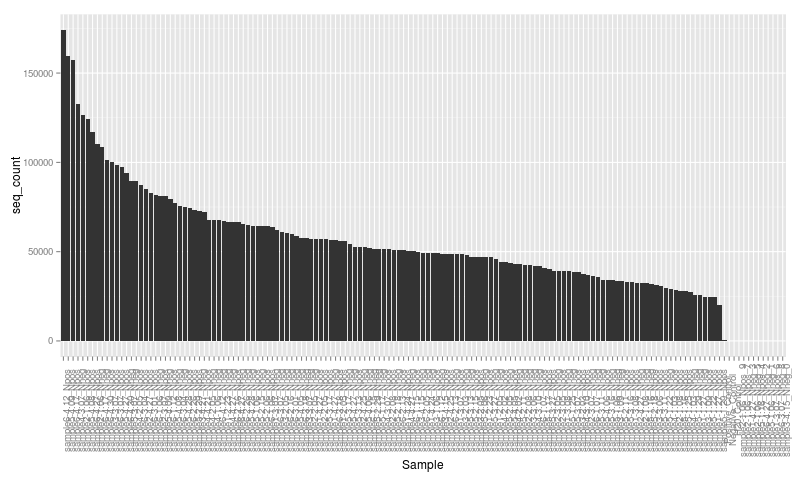

In [43]:
%%R -i df_seq_cnt -w 800
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)

df_seq_cnt = df_seq_cnt %>% 
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme(
        axis.text.x = element_text(angle=90)
    )

## Samples with a very low number of reads

In [44]:
%%R
df_seq_cnt %>% filter(seq_count < 100)

                Sample seq_count rank
1          H20_Control        43   11
2  sample2-1.06_Npos_9         1    1
3  sample2-1.06_Npos_7         1    1
4  sample1-4.27_Nneg_3         1    1
5  sample2-1.06_Nneg_5         1    1
6  sample5-1.16_Npos_4         1    1
7  sample6-4.27_Nneg_2         1    1
8  sample5-1.06_Nneg_1         1    1
9  sample1-3.07_Npos_6         1    1
10 sample6-3.07_Nneg_8         1    1
11 sample3-4.15_Nneg_0         1    1


In [51]:
%%R
df_seq_cnt$seq_count %>% sum

[1] 7912449


In [45]:
%%R
df_seq_cnt %>% head

             Sample seq_count rank
1 sample6-4.12_Npos    174183  149
2 sample5-4.09_Npos    159561  148
3 sample6-4.17_Npos    157536  147
4 sample4-3.07_Nneg    132961  146
5 sample2-1.06_Npos    126528  145
6 sample5-4.08_Npos    124173  144


## Summing by sample

In [ ]:
%%R
# edit table

#df_seq_cnt$Treatment = gsub('_20yrOrg_', '-20yrOrg-', df_seq_cnt$Sample)
#df_seq_cnt$Treatment = gsub('_.+', '', df_seq_cnt$Treatment)
#df_seq_cnt$Rep = gsub('.+D[0-9]+R([0-9]+).+', '\\1', df_seq_cnt$Sample)
#df_seq_cnt$Rep = gsub('.+seqR', '\\1', df_seq_cnt$Rep)
#df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)

In [ ]:
%%R
# summing by sample

#df_seq_cnt_agg = df_seq_cnt %>%
#    group_by(Treatment) %>%
#    summarize(
#        mean_count = mean(seq_count, na.rm=TRUE),
#        stderr_count = sd(seq_count)/sqrt(length(seq_count))
#    )

In [ ]:
%%R
# plotting by treatment

#ggplot(df_seq_cnt_agg, aes(Treatment, mean_count)) +
 #   geom_bar(stat='identity', fill='red', alpha=0.7) +
  #  geom_linerange(aes(ymin=mean_count-stderr_count, ymax=mean_count+stderr_count)) +
   # labs(y='Mean sequence count') +
    #theme(
     #   text = element_text(size=16),
      #  axis.text.x = element_text(angle=90, hjust=1),
       # axis.title.x = element_blank()
    #)